<a id="Introduction"></a>
# Introduction

In the following, I will demonstrate step by step how to build a Machine Learning predictive model step by step.

* [Introduction](#Introduction)
* [Read data](#Read-data)
    * [Import libraries](#Import-libraries) 
    * [Define functions](#Define-functions) 
    * [Get data](#Get-data) 
* [Define the problem statement](#Define-the-problem-statement)
* [Data exploration](#Data-exploration) 
    * [Distribution of Target variable](#Distribution-of-Target-variable) 
    * [Rejecting useless columns](#Rejecting-useless-columns) 
* [Data cleaning](#Data-cleaning)
    * [Missing Values treatment](#Missing-Values-treatment)
    * [Outlier treatment](#Outlier-treatment) 
    * [Scale data](#Scale-data)
    * [Dummy Encoding](#get-dummies) 
* [Feature Selection](#Feature-Selection)
    * [Statistical correlation analysis for category variable](#Statistical-correlation-analysis_Chi_square)
    * [Statistical correlation analysis for continuous variable](#Statistical-correlation-analysis_ANOVA)
* [Model buidling](#Model-buidling)
    * [Trying multiple classification algorithms](#Trying-multiple-classification-algorithms)  
    * [Selecting the best Model](#best-Model)
    * [Hyperparameter tuning](#Hyperparameter-tuning)
    * [Choose threshold](#Choose-threshold)



<a id="Read-data"></a>
# Read data

<a id="Import-libraries"></a>
## Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')
import optbinning
import lightgbm
import xgboost
import json
import datetime as dt

from scipy.stats import chi2_contingency, f_oneway, shapiro, ks_2samp
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

pd.set_option("display.max_column", None)

(CVXPY) May 10 08:49:57 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) May 10 08:49:57 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


<a id="#Define-functions"></a>
## Define functions

In [2]:
def convert_dict_to_df(data, column):
    dict = pd.DataFrame()
    for i in range(0, len(data[column])):
        dictionary = json.loads(data[column][i])
        dictionary = {k:[v] for k,v in dictionary.items()}
        table = pd.DataFrame(dictionary)
        if dict.empty:
            dict = pd.concat([dict, table], axis=1)
        else:
            dict = pd.concat([dict, table], axis=0)

    dict = dict.reset_index(drop = True)
    data = data.drop([column], axis = 1)
    data = pd.concat([data, dict], axis = 1)
    return data


def count_na(data):
    count_na = data.isna().sum().to_frame().rename(columns = {0 : 'count'})
    count_na['percent'] = (data.isna().sum() / data.shape[0] * 100).round(2)
    return count_na


def remove_zero_var(data):
    cnt_unique = pd.DataFrame(data.nunique()).rename(columns = {0: 'unique'})
    zero_var = cnt_unique[cnt_unique['unique'] == 1].index
    data = data.drop(zero_var, axis = 1)
    return data


def plot_hist_subplot(x, fieldname, bins = 10, use_kde = True):
  x = x.dropna()
  xlabel = '{} bins tickers'.format(fieldname)
  ylabel = 'Count obs in {} each bin'.format(fieldname)
  title = 'histogram plot of {} with {} bins'.format(fieldname, bins)
  ax = sns.distplot(x, bins = bins, kde = use_kde)
  ax.set_xlabel(xlabel, fontsize = 10)
  ax.set_ylabel(ylabel, fontsize = 10)
  ax.set_title(title, fontsize = 10)
  return ax


def plot_barchart_subplot(x, fieldname):
  xlabel = 'Group of {}'.format(fieldname)
  ylabel = 'Count obs in {} each bin'.format(fieldname)
  title = 'Barchart plot of {}'.format(fieldname)
  x = x.fillna('Missing')
  df_summary = x.value_counts(dropna = False)
  y_values = df_summary.values
  x_index = df_summary.index
  ax = sns.barplot(x = x_index, y = y_values, order = x_index)

  labels = list(set(x))
  for label, p in zip(y_values, ax.patches):
    ax.annotate(label, (p.get_x()+0.25, p.get_height()+0.15))
  plt.xlabel(xlabel, fontsize = 10)
  plt.ylabel(ylabel, fontsize = 10)
  plt.title(title, fontsize = 10)
  return ax


def Test_Normality(data, ContinuousColumnsList):
    selected_predictors = []
    print('##### Shapiro-Wilk Test Results ##### \n')
    for predictor in ContinuousColumnsList:
        ShapiroResults = shapiro(data[predictor])

        if (ShapiroResults[1] < 0.05):
            print(predictor, 'does NOT follow normal distribution' , '| P-Value:', ShapiroResults[1]) 
        else:
            print(predictor, 'follow normal distribution', '| P-Value:', ShapiroResults[1])
            selected_predictors.append(predictor)
    return(selected_predictors)
    

def FunctionChisq(data, TargetVariable, CategoricalVariablesList):
    selected_predictors = []
    print('##### Chi-Square Results ##### \n')
    for predictor in CategoricalVariablesList:
        CrossTabResult = pd.crosstab(index = data[TargetVariable], columns = data[predictor])
        ChiSqResult = chi2_contingency(CrossTabResult)
        
        if (ChiSqResult[1] < 0.05):
            print(predictor, 'is correlated with', TargetVariable, '| P-Value:', ChiSqResult[1])
            selected_predictors.append(predictor)
        else:
            print(predictor, 'is NOT correlated with', TargetVariable, '| P-Value:', ChiSqResult[1])        
    return(selected_predictors)


def FunctionAnova(data, TargetVariable, ContinuousPredictorList):
    selected_predictors = []
    print('##### ANOVA Results ##### \n')
    for predictor in ContinuousPredictorList:
        CategoryGroupLists = data.groupby(TargetVariable)[predictor].apply(list)
        AnovaResults = f_oneway(*CategoryGroupLists)

        if (AnovaResults[1] < 0.05):
            print(predictor, 'is correlated with', TargetVariable, '| P-Value:', AnovaResults[1])
            selected_predictors.append(predictor)
        else:
            print(predictor, 'is NOT correlated with', TargetVariable, '| P-Value:', AnovaResults[1])
    return(selected_predictors)


def draw_confusion_matrix(cm):
    plt.figure(figsize = (4,4))
    sns.heatmap(cm, annot = True , fmt = 'd', center = 0 ,cmap = 'flare')
    plt.title('Confusion matrix')
    plt.xlabel("Predict label")
    plt.ylabel("True label")
    plt.show()


def KS_Test(data, train_value, test_value):
    print('##### Kolmogorov-Smirnov Results ##### \n')
    KS_result = ks_2samp(train_value, test_value)
    if (KS_result[1] < 0.05):
        print('Both samples NOT follow the same distribution | P-Value:', KS_result[1])
    else:
        print('Both samples follow the same distribution | P-Value:', KS_result[1])  


def _psi(expected, actual, bucket_type, n_bins):
    breakpoints = np.arange(0, n_bins + 1) / (n_bins) * 100
    if bucket_type == "bins":
        breakpoints = np.histogram(expected, n_bins)[1]
    elif bucket_type == "quantiles":
        breakpoints = np.percentile(expected, breakpoints)

    # Calculate frequencies
    expected_percents = np.histogram(expected, breakpoints)[0] / len(expected)
    actual_percents = np.histogram(actual, breakpoints)[0] / len(actual)
    # Clip freaquencies to avoid zero division
    expected_percents = np.clip(expected_percents, a_min=0.0001, a_max=None)
    actual_percents = np.clip(actual_percents, a_min=0.0001, a_max=None)
    # Calculate PSI
    psi_value = (expected_percents - actual_percents) * np.log(expected_percents / actual_percents)
    psi_value = sum(psi_value)
    return psi_value


def calculate_psi(expected, actual, bucket_type, n_bins, axis):
    if len(expected.shape) == 1:
        psi_values = np.empty(len(expected.shape))
    else:
        psi_values = np.empty(expected.shape[axis])
    for i in range(0, len(psi_values)):
        if len(psi_values) == 1:
            psi_values = _psi(expected, actual, bucket_type, n_bins)
        elif axis == 0:
            psi_values[i] = _psi(expected[:, i], actual[:, i], bucket_type, n_bins)
        elif axis == 1:
            psi_values[i] = _psi(expected[i, :], actual[i, :], bucket_type, n_bins)
        return np.array(psi_values)
    
    
def PSI(expected, actual, bucket_type, n_bins, axis):
    print('##### Population Stability Index Results ##### \n')
    PSI_result = calculate_psi(expected, actual, bucket_type, n_bins, axis)
    if (PSI_result < 0.1):
        print('No major change, you can continue with the current model. | PSI-Result:', PSI_result)
    elif (PSI_result >= 0.1 and PSI_result < 0.2):
        print('Moderate population change, use your best judgement. | PSI-Result:', PSI_result)
    else:
        print('Significant population change, model retraining may be required. | PSI-Result:', PSI_result)  


def show_precision_recall_score(y_test, y_pred, threshold):
    y_pred_df           = pd.DataFrame(y_pred)
    y_pred_df.columns   = ['y_prob']
    y_pred_df['y_pred'] = y_pred_df['y_prob'].apply(lambda x: 1 if x >= threshold else 0)
    cm                  = confusion_matrix(y_test,y_pred_df['y_pred'])   
    prec = cm[1][1] / (cm[1][1] + cm[0][1])
    prec = '{:.2f}'.format(prec)
    rec  = cm[1][1] / (cm[1][1] + cm[1][0])
    rec  = '{:.2f}'.format(rec)
    print(f'Threshold: {threshold} | Precision: {prec} | Recall: {rec}')

<a id="Get-data"></a>
## Get data

In [3]:
path  = 'D:/python code/TEST_DS'
data = pd.read_csv(path + '/demographic.csv').iloc[: , 1:]

<a id="#Define-the-problem-statement"></a>
# Define the problem statement

Define the variable
> * **Target variable :** flag_bad
>  
> * **Predictors variable:** de_age, de_gender,	de_date_joined,	de_num_friends,	de_monthly_salary etc.
  

Determining the type of Machine Learning

> * Based on the problem statement we need to create a supervised ML classification model, as the target variable is categorical.


<a id="Data-exploration"></a>
# Data exploration

In [4]:
# Looking at sample rows in the data
data.head()

,flag_bad,de_age,de_gender,de_date_joined,de_num_friends,de_monthly_salary,de_employment_type,de_employment_duration,de_accomodation_type,de_education,de_marital_status,de_children,ph_total_contacts,ph_other_device_info,ph_call_log_stats,ph_country_code,ph_app_list,fb_gender,fb_dob,fb_last_updated_date,fb_relation
0,0,26,1,08/04/2018 14:50,2535,3000000,1,51,4,2,2,0,66,"{""device_codename"": ""HM2014817"", ""brand"": ""Xia...","{""percent_incoming_nighttime"": 1.83, ""percent_...",id,"['com.google.android.music', 'com.facebook.orc...",male,11/23/1991,2017-12-21T04:38:00+0000,Married
1,0,22,1,02/01/2018 17:17,685,4000000,1,28,4,4,1,0,69,"{""device_codename"": ""A1601"", ""brand"": ""OPPO""}","{""percent_incoming_nighttime"": 0.0, ""percent_o...",id,"['com.google.android.instantapps.supervisor', ...",male,01/20/1995,2017-11-25T17:23:09+0000,NaN
2,1,32,1,01/01/2018 16:39,1765,7000000,1,35,4,4,2,2,315,"{""device_codename"": ""A1601"", ""brand"": ""OPPO""}","{""percent_incoming_nighttime"": 6.65, ""percent_...",id,"['com.tencent.ibg.joox', 'com.mrgames.larvaact...",male,10/13/1985,2017-12-23T18:05:57+0000,Married
3,0,31,2,04/01/2018 22:36,407,20000000,3,37,4,3,2,2,84,"{""device_codename"": ""A1601"", ""brand"": ""OPPO""}","{""percent_incoming_nighttime"": 0.0, ""percent_o...",id,"['com.kfit.fave', 'app.bpjs.mobile', 'com.redd...",female,07/27/1986,2017-12-05T09:37:19+0000,Married
4,0,27,1,02/01/2018 18:12,3064,3000000,1,36,4,3,1,0,0,"{""device_codename"": ""1609"", ""brand"": ""vivo""}","{""percent_incoming_nighttime"": 0.0, ""percent_o...",id,"['com.lenovo.anyshare.gps', 'com.UCMobile.intl...",male,07/05/1990,2017-12-03T09:09:48+0000,In a relationship


In [5]:
# Observing the summarized information of data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41022 entries, 0 to 41021
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   flag_bad                41022 non-null  int64 
 1   de_age                  41022 non-null  int64 
 2   de_gender               41022 non-null  int64 
 3   de_date_joined          41022 non-null  object
 4   de_num_friends          41022 non-null  int64 
 5   de_monthly_salary       41022 non-null  int64 
 6   de_employment_type      41022 non-null  int64 
 7   de_employment_duration  41022 non-null  int64 
 8   de_accomodation_type    41022 non-null  int64 
 9   de_education            41022 non-null  int64 
 10  de_marital_status       41022 non-null  int64 
 11  de_children             41022 non-null  int64 
 12  ph_total_contacts       41022 non-null  int64 
 13  ph_other_device_info    41022 non-null  object
 14  ph_call_log_stats       38935 non-null  object
 15  ph

In [6]:
# Looking at the descriptive statistics of the data
data.describe(include = 'all')

,flag_bad,de_age,de_gender,de_date_joined,de_num_friends,de_monthly_salary,de_employment_type,de_employment_duration,de_accomodation_type,de_education,de_marital_status,de_children,ph_total_contacts,ph_other_device_info,ph_call_log_stats,ph_country_code,ph_app_list,fb_gender,fb_dob,fb_last_updated_date,fb_relation
count,41022.000000,41022.000000,41022.000000,41022,41022.000000,4.102200e+04,41022.000000,41022.000000,41022.0,41022.000000,41022.000000,41022.000000,41022.000000,41022,38935,40997,41022,39509,31369,39552,14561
unique,NaN,NaN,NaN,37120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1058,36384,8,40097,2,8931,39469,17
top,NaN,NaN,NaN,18/03/2018 14:59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""device_codename"": ""mido"", ""brand"": ""xiaomi""}","{""percent_incoming_nighttime"": 0.0, ""percent_o...",id,[],male,08/17/1945,2018-04-11T09:55:54+0000,Married
freq,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1871,1308,40984,913,24013,29,2,6327
mean,0.129687,28.170908,1.388474,NaN,1270.023987,5.182707e+06,1.397177,33.437887,4.0,2.636268,1.537858,0.706962,127.032568,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,0.335962,6.537795,0.487409,NaN,1188.849670,3.751306e+06,0.689464,16.586586,0.0,0.950850,0.569079,0.929021,319.078176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,18.000000,1.000000,NaN,-1.000000,0.000000e+00,1.000000,0.000000,4.0,1.000000,1.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,0.000000,23.000000,1.000000,NaN,437.000000,3.000000e+06,1.000000,18.000000,4.0,2.000000,1.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,0.000000,27.000000,1.000000,NaN,867.000000,4.000000e+06,1.000000,36.000000,4.0,2.000000,2.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,0.000000,32.000000,2.000000,NaN,1663.000000,5.000000e+06,2.000000,51.000000,4.0,3.000000,2.000000,1.000000,144.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Typically if the numer of unique values are < 10 then the variable is likely to be a category otherwise continuous
data.nunique().sort_values()

de_accomodation_type          1
flag_bad                      2
fb_gender                     2
de_gender                     2
de_employment_type            4
de_marital_status             4
de_education                  5
de_children                   5
ph_country_code               8
fb_relation                  17
de_monthly_salary            40
de_age                       50
de_employment_duration       52
ph_other_device_info       1058
ph_total_contacts          1588
de_num_friends             4531
fb_dob                     8931
ph_call_log_stats         36384
de_date_joined            37120
fb_last_updated_date      39469
ph_app_list               40097
dtype: int64

<a id="#Distribution-of-Target-variable"></a>
## Distribution of Target variable

In the graph below we can see an imbalance between the two classes, which is quite normal when predicting default probability.

> Therefore, we will not use the accuracy score to evaluate the performance of the model because the scores are unevenly distributed among the classes.

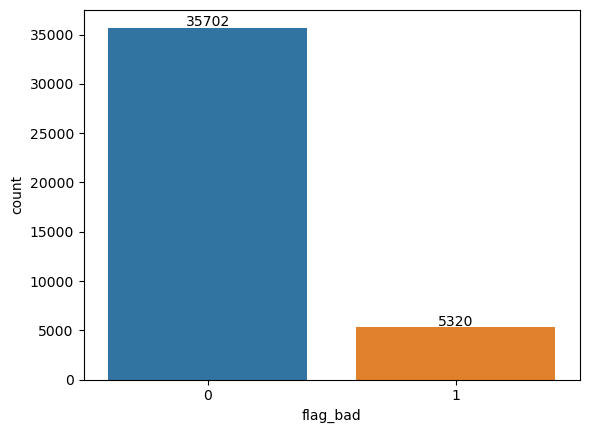

In [8]:
ax = sns.countplot(data['flag_bad'])
for rect in ax.patches:
            ax.annotate(format(rect.get_height(), '.0f'),
                   (rect.get_x() + rect.get_width() / 2,
                    rect.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 4),
                   textcoords='offset points')

<a id="#Rejecting-useless-columns"></a>
## Rejecting useless columns

In this data column de_date_joined is useless to us because it does not affect the probability of default.

Since we have de_age and de_gender columns, we remove de_date_joined and fb_gender columns to avoid repeating information. We also leave out columns that have only one value in all rows (de_accomodation_type column).

Hence, we will remove these columns from the data.

In [9]:
data = data.drop(['de_date_joined','fb_gender','fb_dob','ph_app_list'], axis = 1)
data = remove_zero_var(data)

<a id="#Data-cleaning"></a>
# Data cleaning

<a id="#Missing-Values-treatment"></a>
## Missing values treatment

Because the column ph_call_log_stats has NA values that we are not sure enough to replace with another value and the number of missing is not much, we will leave out these missing lines.

For column ph_country_code, fb_relation the frequency of most value is very small so we gonna group them into other

The fb_relation column has a rather large number of missing so I will replace the NA value with Missing instead of using mode.

In [10]:
data = data.loc[~data['ph_call_log_stats'].isna()].reset_index(drop = True)

threshold = 0.001
drop = data['ph_country_code'].value_counts(normalize = True, dropna = False).loc[lambda x: x < threshold].index
data.loc[data['ph_country_code'].isin(drop), 'ph_country_code'] = 'other'

threshold = 0.01
drop = data['fb_relation'].value_counts(normalize = True, dropna = False).loc[lambda x: x < threshold].index
data.loc[data['fb_relation'].isin(drop), 'fb_relation'] = 'other'
data['fb_relation'] = data['fb_relation'].fillna('Not Defined')

In [11]:
# Convert dictionary to dataframe
data = convert_dict_to_df(data, 'ph_other_device_info')
data = convert_dict_to_df(data, 'ph_call_log_stats')
data['brand'] = data['brand'].str.upper()

In [12]:
threshold = 0.01
drop = data['brand'].value_counts(normalize = True, dropna = False).loc[lambda x: x < threshold].index
data.loc[data['brand'].isin(drop), 'brand'] = 'other'

We will not use the fb_last_updated_date column instead we will use the year and month column taken from fb_last_updated_date because the values from the column are quite messy

In [13]:
data['fb_last_updated_date'] = pd.to_datetime(data['fb_last_updated_date'], infer_datetime_format = '%Y-%m-%dT%H:%M:%S')
data['fb_last_updated_year'] = data['fb_last_updated_date'].dt.year
data['fb_last_updated_month'] = data['fb_last_updated_date'].dt.month
data['fb_last_updated_year'] = data['fb_last_updated_year'].fillna(data['fb_last_updated_year'].mode()[0]).astype('object')
data['fb_last_updated_month'] = data['fb_last_updated_month'].fillna(data['fb_last_updated_month'].mode()[0]).astype('object')
data = data.drop(['fb_last_updated_date', 'device_codename'], axis = 1)

For columns with the number of values less than 10 will be converted to category.

In [14]:
cnt_unique = pd.DataFrame(data.drop(['flag_bad'], axis = 1).nunique())
unique_val = cnt_unique[cnt_unique[0] < 10].index.tolist()
data[unique_val] = data[unique_val].astype('object')

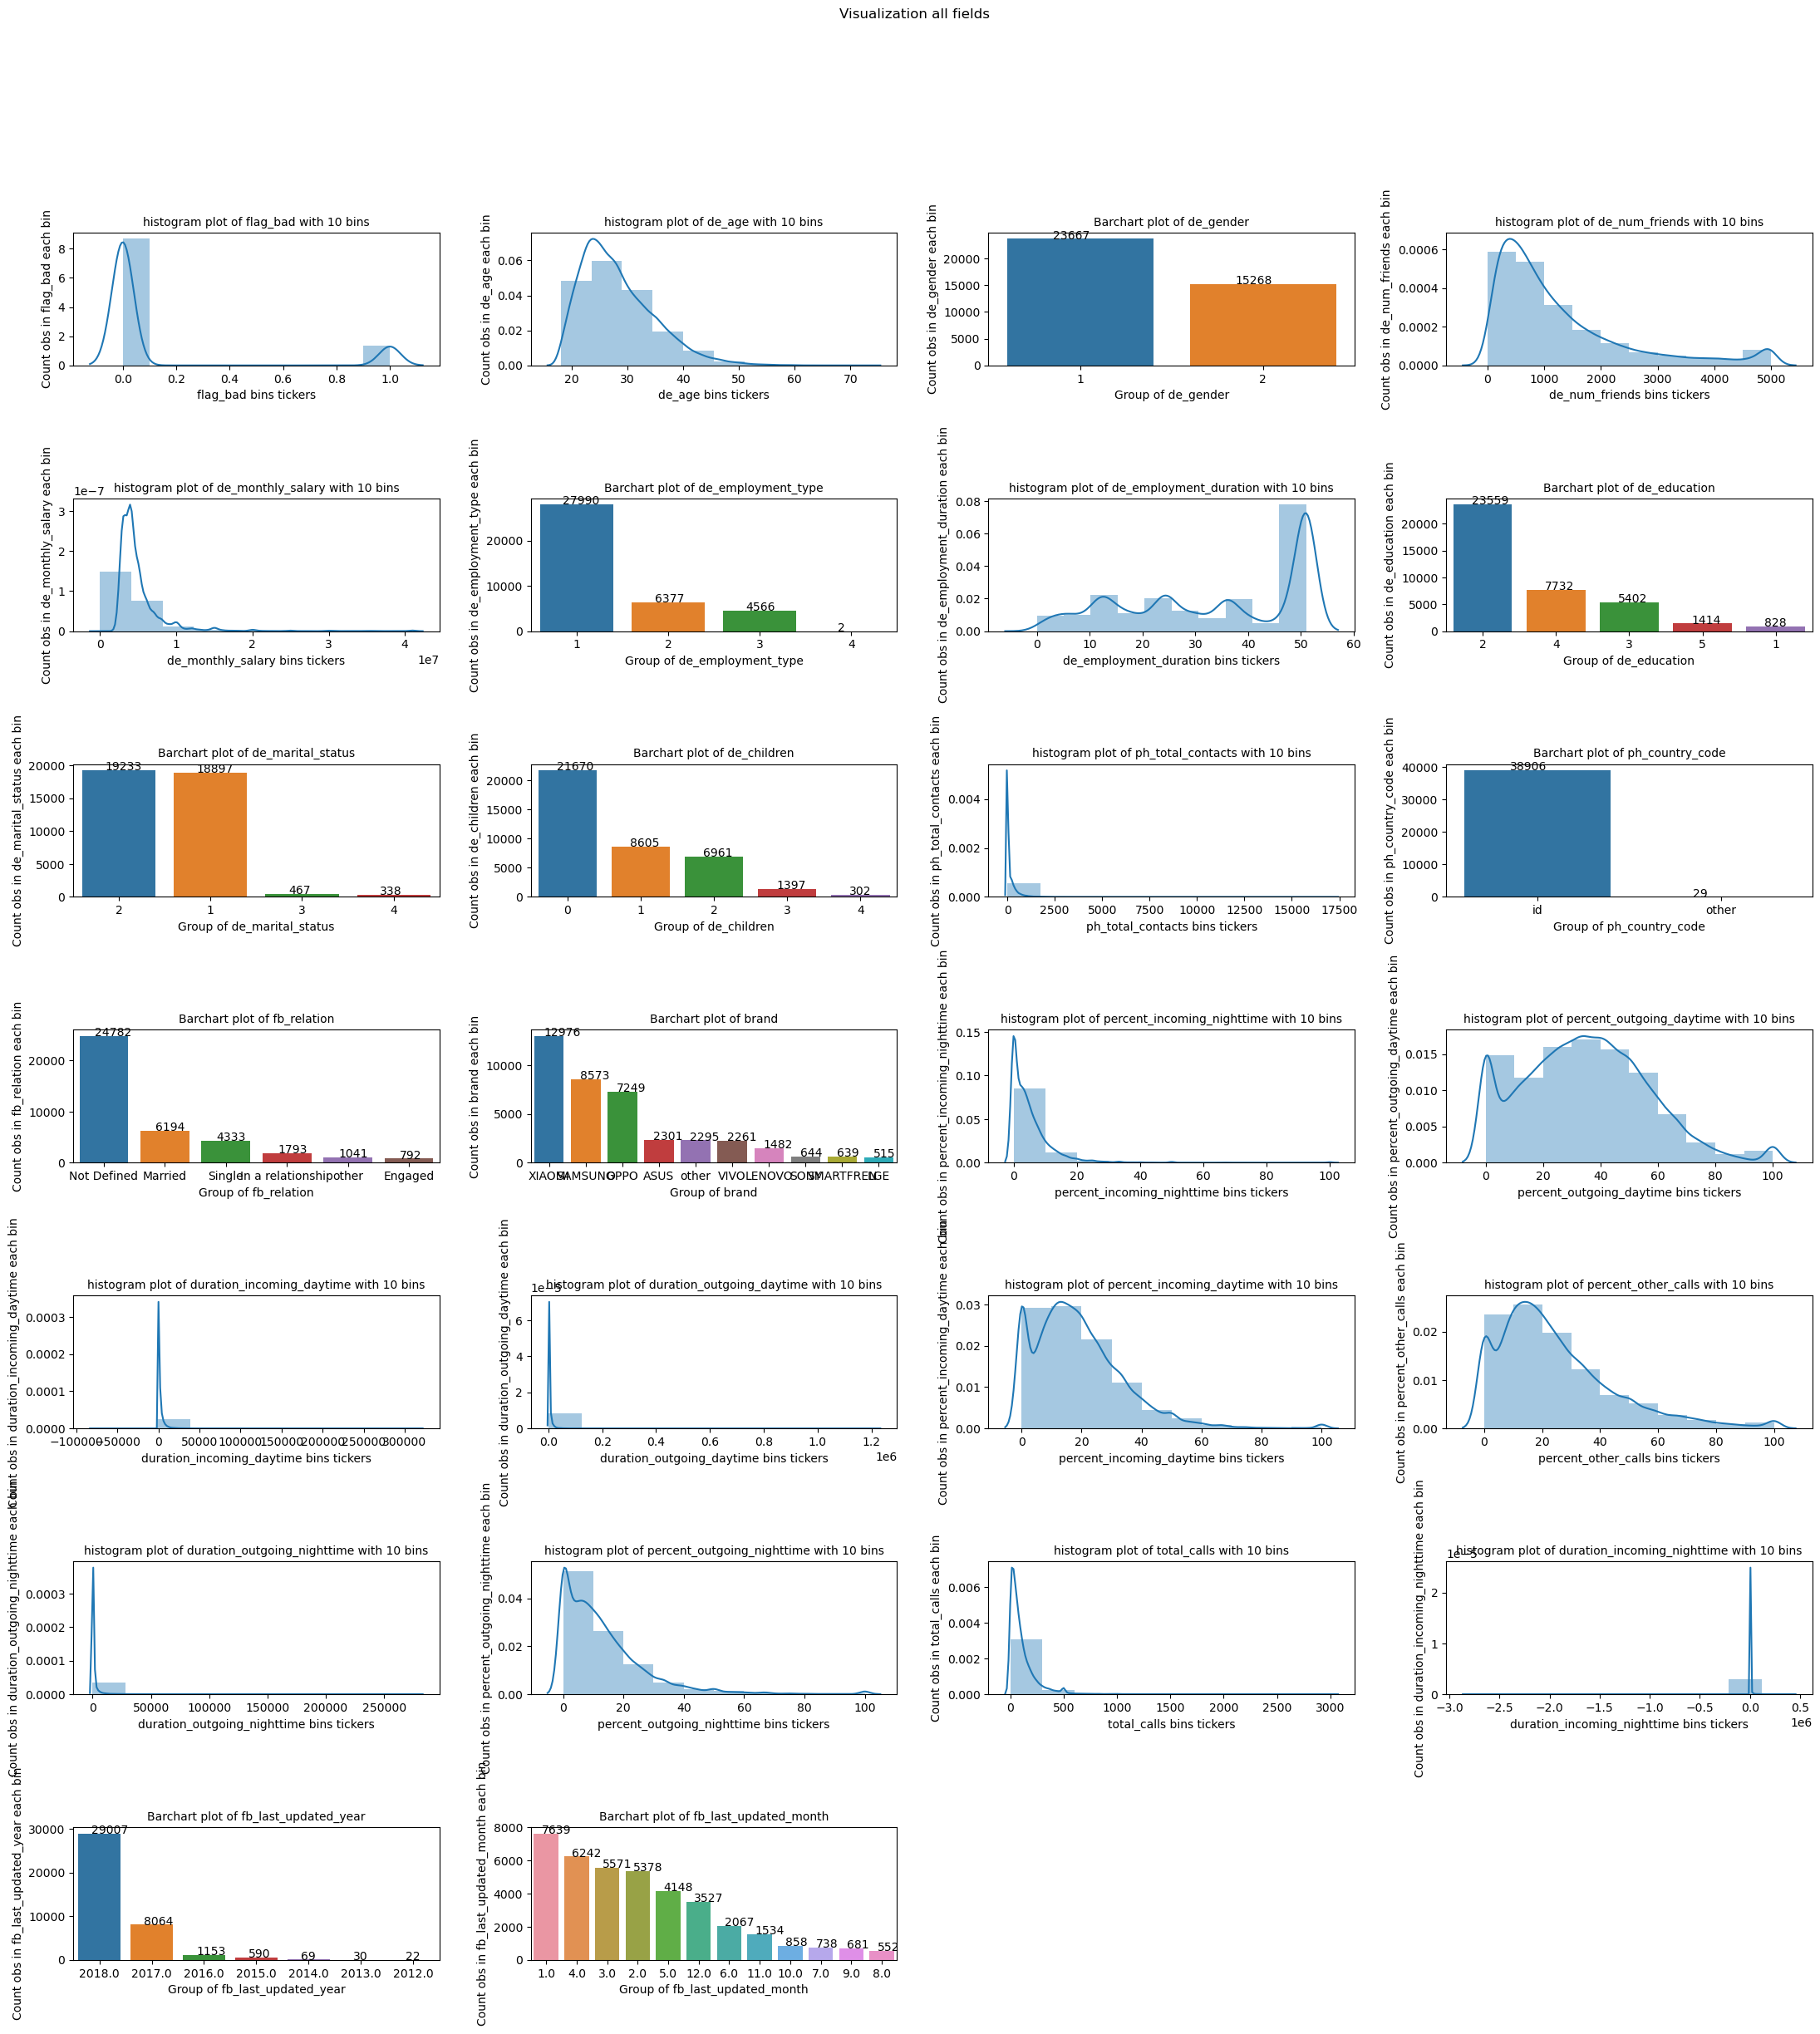

In [15]:
fig = plt.figure(figsize=(27, 27))
fig.subplots_adjust(hspace=1.0, wspace=0.25)

for i, (fieldname, dtype) in enumerate(zip(data.columns, data.dtypes.values)):
  if i <= 27:
    ax_i = fig.add_subplot(7, 4, i+1)
    if dtype in ['float64', 'int64']:
      ax_i = plot_hist_subplot(data[fieldname], fieldname=fieldname)
    else:
      ax_i = plot_barchart_subplot(data[fieldname], fieldname=fieldname)
      
fig.suptitle('Visualization all fields')
plt.show()

In [16]:
## Split the data into category and numeric columns
cat_col = data.select_dtypes('object')
num_col = data.select_dtypes(exclude = ['object','bool']).drop(['flag_bad'], axis = 1)

<a id="#Outlier-treatment"></a>
## Outlier treatment

First of all, we will check if there are any continous columns that follow a normal distribution.

In [17]:
h_num_col = num_col.nunique().sort_values().to_frame().rename(columns = {0:'unique'})
# select columns with more than 10 unique values
outlier_col = h_num_col[h_num_col['unique'] > 10] 

Shapiro-Wilk test is conducted to check if the data is normal or not.

> **H0: data does NOT follow normal distribution**

> **H1: data follow normal distribution**

In [18]:
SelectedColumns = Test_Normality(data, data[outlier_col.index])
nor_col = data[SelectedColumns]

##### Shapiro-Wilk Test Results ##### 

de_monthly_salary does NOT follow normal distribution | P-Value: 0.0
de_age does NOT follow normal distribution | P-Value: 0.0
de_employment_duration does NOT follow normal distribution | P-Value: 0.0
total_calls does NOT follow normal distribution | P-Value: 0.0
ph_total_contacts does NOT follow normal distribution | P-Value: 0.0
percent_incoming_nighttime does NOT follow normal distribution | P-Value: 0.0
percent_outgoing_nighttime does NOT follow normal distribution | P-Value: 0.0
percent_incoming_daytime does NOT follow normal distribution | P-Value: 0.0
de_num_friends does NOT follow normal distribution | P-Value: 0.0
duration_incoming_nighttime does NOT follow normal distribution | P-Value: 0.0
percent_other_calls does NOT follow normal distribution | P-Value: 0.0
duration_outgoing_nighttime does NOT follow normal distribution | P-Value: 0.0
percent_outgoing_daytime does NOT follow normal distribution | P-Value: 0.0
duration_outgoing_daytim

<a id="#Scale-data"></a>
## Scale data

Since all columns that we choose are not follow normal distribution, we will use the Robust Scaler to resists the pull of outliers.

In [19]:
scale = RobustScaler()
data[outlier_col.index] = scale.fit_transform(data[outlier_col.index])
scale_num_col = data.select_dtypes(exclude = 'object')

<a id="#get-dummies"></a>
##  Dummy Encoding

We will use dummy encoding to convert categorical data into a numerical representation that the algorithms can understand.

In [20]:
dum_col = pd.get_dummies(data[cat_col.columns], drop_first = True).astype('int64')
data = pd.concat([data, dum_col], axis = 1)

<a id="#Feature-Selection"></a>
# Feature Selection

Now its time to finally choose columns (Features) which are correlated to the Target variable. This can be done directly by measuring the correlation values or ANOVA/Chi-Square tests.

In [21]:
data.drop(data[cat_col.columns], axis = 1, inplace = True)

n_cat_col = dum_col
n_num_col = scale_num_col
target_col = data['flag_bad']

Chi-Square test is conducted to check the correlation between two categorical variables

> **H0: The two columns are NOT related to each other**

> **H1: The two columns are related to each other**


In [22]:
SelectedCatPredictors = FunctionChisq(data = data, TargetVariable ='flag_bad', CategoricalVariablesList = n_cat_col)
f_cat_col = n_cat_col[SelectedCatPredictors]

##### Chi-Square Results ##### 

de_gender_2 is correlated with flag_bad | P-Value: 1.1341419536017012e-15
de_employment_type_2 is correlated with flag_bad | P-Value: 1.1563135688931586e-11
de_employment_type_3 is correlated with flag_bad | P-Value: 2.1569545529177722e-11
de_employment_type_4 is NOT correlated with flag_bad | P-Value: 0.6243584098522275
de_education_2 is correlated with flag_bad | P-Value: 9.012076250835397e-29
de_education_3 is correlated with flag_bad | P-Value: 0.0016733290367753676
de_education_4 is correlated with flag_bad | P-Value: 1.5111690670401248e-17
de_education_5 is correlated with flag_bad | P-Value: 3.2908166646226975e-14
de_marital_status_2 is correlated with flag_bad | P-Value: 0.02067605016534052
de_marital_status_3 is correlated with flag_bad | P-Value: 7.7021083532521e-06
de_marital_status_4 is correlated with flag_bad | P-Value: 1.8714789913405384e-11
de_children_1 is NOT correlated with flag_bad | P-Value: 0.20294457816670347
de_children_2 is corr

<a id="#Statistical-correlation-analysis_ANOVA"></a>
## Statistical correlation analysis for continuous variable

Analysis of variance(ANOVA) is performed to check if there is any relationship between the given continuous and categorical variable

> **H0: There is NO relation between the given variables (i.e. The average(mean) values of the numeric Predictor variable is same for all the groups in the categorical Target variable)**

> **H1: There is a relation between the given variables**

In [23]:
SelectedNumPredictors = FunctionAnova(data = data, TargetVariable='flag_bad', ContinuousPredictorList = n_num_col)
f_num_col = n_num_col[SelectedNumPredictors]

##### ANOVA Results ##### 

flag_bad is correlated with flag_bad | P-Value: 0.0
de_age is correlated with flag_bad | P-Value: 0.0045360850831777716
de_num_friends is NOT correlated with flag_bad | P-Value: 0.6158467067645584
de_monthly_salary is NOT correlated with flag_bad | P-Value: 0.19427806306372966
de_employment_duration is correlated with flag_bad | P-Value: 3.7837852974627454e-20
ph_total_contacts is NOT correlated with flag_bad | P-Value: 0.7672659835912478
percent_incoming_nighttime is correlated with flag_bad | P-Value: 3.3203781848440327e-05
percent_outgoing_daytime is correlated with flag_bad | P-Value: 9.246317357754424e-06
duration_incoming_daytime is NOT correlated with flag_bad | P-Value: 0.15817511022487668
duration_outgoing_daytime is correlated with flag_bad | P-Value: 0.004434644309472657
percent_incoming_daytime is correlated with flag_bad | P-Value: 6.112336891336759e-41
percent_other_calls is correlated with flag_bad | P-Value: 2.0024643605534775e-20
duration_ou

<a id="#Model buidling"></a>
# Model buidling

70% of data is used as Training data and the rest 30% is used as Testing data.

In [24]:
f_num_col.drop(['flag_bad'], axis = 1, inplace = True)
data = pd.concat([f_cat_col, f_num_col, target_col], axis = 1)
x = data.drop(['flag_bad'], axis = 1)
y = data['flag_bad']

Since our data is unbalanced, we will use SMOTE to help models to learn more about the properties of the minority class.

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state= 42, stratify=y)

print('x_train:', x_train.shape)
print('y_train:', y_train.shape)
print('x_test:', x_test.shape)
print('y_test:', y_test.shape)

oversample = SMOTE()
x_train, y_train = oversample.fit_resample(x_train, y_train)

x_train: (27254, 33)
y_train: (27254,)
x_test: (11681, 33)
y_test: (11681,)


<a id="#Trying-multiple-classification-algorithms"></a>
## Trying multiple classification algorithms

In [26]:
lreg = LogisticRegression(max_iter=500)
rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=25)
lgb = LGBMClassifier(max_depth = 10, reg_alpha =  0)
xgb = XGBClassifier(n_estimators = 100, max_depth = 5, min_child_weight = 1, scale_pos_weight = 1)

def model_compare(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42, stratify=y)
    oversample = SMOTE()
    x_train, y_train = oversample.fit_resample(x_train, y_train)
    
    list_model = [lreg, rf, lgb, xgb]
    for i in list_model:
        fitted_model = i.fit(x_train, y_train)
        y_train_pred = fitted_model.predict(x_train)
        y_test_pred = fitted_model.predict(x_test)
        y_train_proba_pred = fitted_model.predict_proba(x_train)[:,1]
        y_test_proba_pred = fitted_model.predict_proba(x_test)[:,1]
        print('*'*40)
        print('Model: ', i)
        print('Classification_report for train_set')
        print(classification_report(y_train, y_train_pred))
        print('Classification_report for test_set')
        print(classification_report(y_test, y_test_pred))
        print('*'*40)
        print('Test on distribution of a continuous response variable has changed between train and test set')
        print(KS_Test(data, y_train_proba_pred, y_test_proba_pred))
        print(' '*40)
        print(PSI(y_train_proba_pred, y_test_proba_pred, bucket_type="bins", n_bins=10, axis=0))
        print(' '*40)

In [27]:
model_compare(x,y)

****************************************
Model:  LogisticRegression(max_iter=500)
Classification_report for train_set
              precision    recall  f1-score   support

           0       0.69      0.68      0.69     23641
           1       0.69      0.70      0.69     23641

    accuracy                           0.69     47282
   macro avg       0.69      0.69      0.69     47282
weighted avg       0.69      0.69      0.69     47282

Classification_report for test_set
              precision    recall  f1-score   support

           0       0.88      0.68      0.77     10132
           1       0.15      0.38      0.22      1549

    accuracy                           0.64     11681
   macro avg       0.52      0.53      0.49     11681
weighted avg       0.78      0.64      0.70     11681

****************************************
Test on distribution of a continuous response variable has changed between train and test set
##### Kolmogorov-Smirnov Results ##### 

Both samples NOT 

To evaluate the effectiveness of each model, we will observe the recall_score rather than the precision_score that predicted by the data models.

If the recall is low, it can cost us a lot to provide a loan that customers can't afford to pay back.

After looking at the classification report of each model, I decide to choose model LightGBM to process in the next step since it calculation was faster, so the LightGBM model will be selected as the model to deploy.

<a id="#best-Model"></a>
## Selecting the best Model

In [28]:
lgb = LGBMClassifier(max_depth = 10).fit(x_train,y_train)

y_train_pred = lgb.predict(x_train)
y_test_pred = lgb.predict(x_test)

print(classification_report(y_train,y_train_pred))
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.86      0.98      0.91     23641
           1       0.97      0.83      0.90     23641

    accuracy                           0.91     47282
   macro avg       0.91      0.91      0.90     47282
weighted avg       0.91      0.91      0.90     47282

              precision    recall  f1-score   support

           0       0.87      0.97      0.92     10132
           1       0.29      0.09      0.13      1549

    accuracy                           0.85     11681
   macro avg       0.58      0.53      0.52     11681
weighted avg       0.80      0.85      0.81     11681



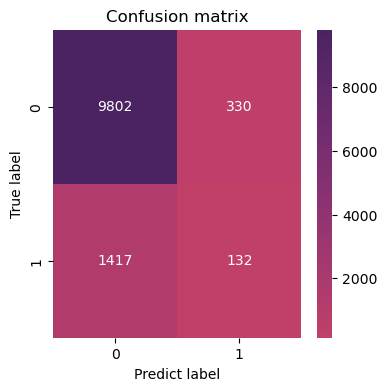

In [29]:
cm = confusion_matrix(y_test,y_test_pred)
draw_confusion_matrix(cm)

<a id="#Hyperparameter-tuning"></a>
## Hyperparameter tuning

After the LightGBM model is selected, we will start to adjust the hyperparameter to select the parameter that maximizes the model's performance and minimize a predefined loss function to produce better results with fewer errors.

In [30]:
param_grid = {
    'class_weight': [None, 'balanced'],
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': [int(x) for x in np.linspace(start = 30, stop = 150, num = 10)],
    'reg_alpha': [0,0.5,1],
    'reg_lambda': [0,0.5,1],
    'learning_rate': [0.01,0.1,0.5],
    'subsample_for_bin': [20000,50000,100000,120000,150000],
    'min_child_samples': [20,50,100,200,500],
    'colsample_bytree': [0.6,0.8,1],
    "max_depth": [5,10,50,100]
}

lgb_random = RandomizedSearchCV(estimator = lgb, param_distributions = param_grid, n_iter = 100, cv = 5, verbose = 2, scoring = 'recall', n_jobs = -1)
lgb_random.fit(x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=LGBMClassifier(max_depth=10), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'boosting_type': ['gbdt', 'goss',
                                                          'dart'],
                                        'class_weight': [None, 'balanced'],
                                        'colsample_bytree': [0.6, 0.8, 1],
                                        'learning_rate': [0.01, 0.1, 0.5],
                                        'max_depth': [5, 10, 50, 100],
                                        'min_child_samples': [20, 50, 100, 200,
                                                              500],
                                        'num_leaves': [30, 43, 56, 70, 83, 96,
                                                       110, 123, 136, 150],
                                        'reg_alpha': [0, 0.5, 1],
                                        'reg_lambda': [0, 0.5, 1],
                   

In [31]:
print('Best accuracy_score:', lgb_random.best_score_)
print('Best Parameters:', lgb_random.best_params_)
best_random = lgb_random.best_estimator_
lgb = best_random.fit(x_train,y_train)

Best accuracy_score: 0.8425553672322448
Best Parameters: {'subsample_for_bin': 120000, 'reg_lambda': 1, 'reg_alpha': 0.5, 'num_leaves': 123, 'min_child_samples': 50, 'max_depth': 10, 'learning_rate': 0.5, 'colsample_bytree': 0.6, 'class_weight': None, 'boosting_type': 'gbdt'}


              precision    recall  f1-score   support

           0       0.88      0.95      0.91     10132
           1       0.27      0.11      0.15      1549

    accuracy                           0.84     11681
   macro avg       0.57      0.53      0.53     11681
weighted avg       0.79      0.84      0.81     11681



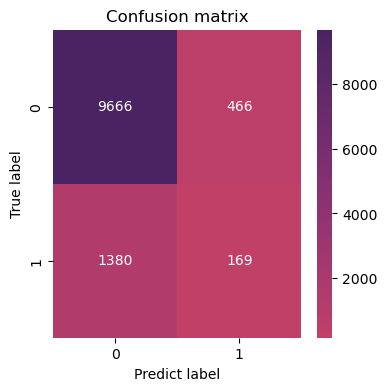

In [32]:
y_test_pred = lgb.predict(x_test)

print(classification_report(y_test, y_test_pred))
cm = confusion_matrix(y_test, y_test_pred)
draw_confusion_matrix(cm)

<a id="#Choose-threshold"></a>
## Choose threshold

Best threshold = 0.080404, F-score= 0.277


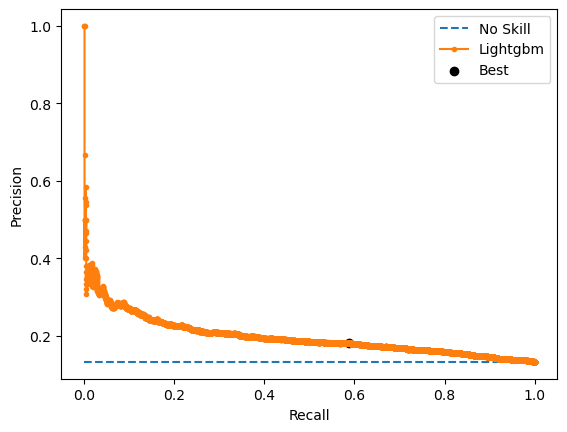

In [53]:
yhat = lgb.predict_proba(x_test)[: ,1]

precision, recall, thresholds = precision_recall_curve(y_test,yhat)
fscore = (2*precision*recall) /(precision+recall)
ix = np.argmax(fscore)
print('Best threshold = %F, F-score= %.3f'%(thresholds[ix],fscore[ix]))
no_skill = len(y_test[y_test ==1 ])/len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle = '--', label ='No Skill')
plt.plot(recall,precision,marker ='.', label = 'Lightgbm')
plt.scatter(recall[ix],precision[ix], marker = 'o', color = 'black', label ='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [34]:
feature_list = x.columns.to_list()

## Validation with Actual Data
for threshold in np.arange(0.1, 0.9, step = 0.1):
    print('*'*40)
    y_actual = y_test
    y_proba = lgb.predict_proba(x_test[feature_list])[:, 1]
    y_pred = [1 if x >= threshold else 0 for x in y_proba]

    df_y           = pd.DataFrame(y_proba)
    df_y.columns   = ['y_prob']
    df_y['y_pred'] = df_y['y_prob'].apply(lambda x: 1 if x >= threshold else 0)
    show_precision_recall_score(y_actual, y_proba, round(threshold, 2))
    print(confusion_matrix(y_actual, df_y['y_pred']))

****************************************
Threshold: 0.1 | Precision: 0.18 | Recall: 0.52
[[6566 3566]
 [ 750  799]]
****************************************
Threshold: 0.2 | Precision: 0.20 | Recall: 0.33
[[8171 1961]
 [1045  504]]
****************************************
Threshold: 0.3 | Precision: 0.22 | Recall: 0.22
[[8935 1197]
 [1204  345]]
****************************************
Threshold: 0.4 | Precision: 0.24 | Recall: 0.16
[[9356  776]
 [1304  245]]
****************************************
Threshold: 0.5 | Precision: 0.27 | Recall: 0.11
[[9666  466]
 [1380  169]]
****************************************
Threshold: 0.6 | Precision: 0.28 | Recall: 0.07
[[9854  278]
 [1442  107]]
****************************************
Threshold: 0.7 | Precision: 0.31 | Recall: 0.04
[[9988  144]
 [1484   65]]
****************************************
Threshold: 0.8 | Precision: 0.36 | Recall: 0.02
[[10069    63]
 [ 1514    35]]


<AxesSubplot:>

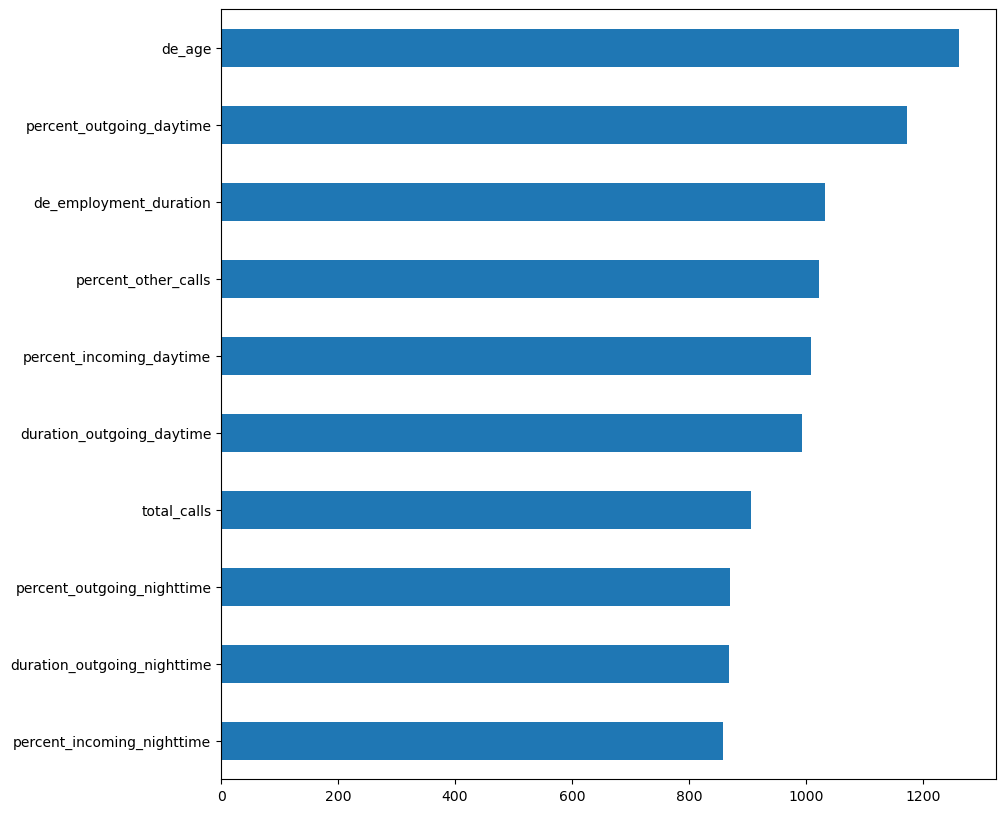

In [35]:
plt.figure(figsize = (10,10))
importance  = lgb.feature_importances_
weight = pd.Series(importance, index= x.columns.values)
weight.sort_values().tail(10).plot(kind = 'barh')

Above are the top 10 features that contributes most to the model prediction. 